# Importing the dataset

In [4]:
import pandas as pd

df = pd.read_csv("../data/INvideos.csv")

df.head()


,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description
0,kzwfHumJyYc,17.14.11,Sharry Mann: Cute Munda ( Song Teaser) | Parmi...,Lokdhun Punjabi,1,2017-11-12T12:20:39.000Z,"sharry mann|""sharry mann new song""|""sharry man...",1096327,33966,798,882,https://i.ytimg.com/vi/kzwfHumJyYc/default.jpg,False,False,False,Presenting Sharry Mann latest Punjabi Song Cu...
1,zUZ1z7FwLc8,17.14.11,"पीरियड्स के समय, पेट पर पति करता ऐसा, देखकर दं...",HJ NEWS,25,2017-11-13T05:43:56.000Z,"पीरियड्स के समय|""पेट पर पति करता ऐसा""|""देखकर द...",590101,735,904,0,https://i.ytimg.com/vi/zUZ1z7FwLc8/default.jpg,True,False,False,"पीरियड्स के समय, पेट पर पति करता ऐसा, देखकर दं..."
2,10L1hZ9qa58,17.14.11,Stylish Star Allu Arjun @ ChaySam Wedding Rece...,TFPC,24,2017-11-12T15:48:08.000Z,Stylish Star Allu Arjun @ ChaySam Wedding Rece...,473988,2011,243,149,https://i.ytimg.com/vi/10L1hZ9qa58/default.jpg,False,False,False,Watch Stylish Star Allu Arjun @ ChaySam Weddin...
3,N1vE8iiEg64,17.14.11,Eruma Saani | Tamil vs English,Eruma Saani,23,2017-11-12T07:08:48.000Z,"Eruma Saani|""Tamil Comedy Videos""|""Films""|""Mov...",1242680,70353,1624,2684,https://i.ytimg.com/vi/N1vE8iiEg64/default.jpg,False,False,False,This video showcases the difference between pe...
4,kJzGH0PVQHQ,17.14.11,why Samantha became EMOTIONAL @ Samantha naga ...,Filmylooks,24,2017-11-13T01:14:16.000Z,"Filmylooks|""latest news""|""telugu movies""|""telu...",464015,492,293,66,https://i.ytimg.com/vi/kJzGH0PVQHQ/default.jpg,False,False,False,why Samantha became EMOTIONAL @ Samantha naga ...


# Right now your model cannot learn because:

## views is a raw number (1000, 50000, 2M…)

Too noisy to predict directly

So we convert it into categories.

In [5]:
df['views'].describe()


count    3.735200e+04
mean     1.060478e+06
std      3.184932e+06
min      4.024000e+03
25%      1.239155e+05
50%      3.045860e+05
75%      7.992912e+05
max      1.254322e+08
Name: views, dtype: float64

Categorising views

In [6]:
def categorize_views(views):
    if views < 50000:
        return "Low"
    elif views < 200000:
        return "Medium"
    elif views < 1000000:
        return "High"
    else:
        return "Viral"

df['view_category'] = df['views'].apply(categorize_views)


In [7]:
df[['views', 'view_category']].head()





,views,view_category
0,1096327,Viral
1,590101,High
2,473988,High
3,1242680,Viral
4,464015,High


In [8]:
#Value Counts
df['view_category'].value_counts()

view_category
High      15488
Medium    11274
Viral      7632
Low        2958
Name: count, dtype: int64

# Data Cleaning

In [9]:
df = df.drop(columns=[
    'video_id',
    'thumbnail_link',
    'trending_date',
    'comments_disabled',
    'ratings_disabled',
    'video_error_or_removed'
])


In [10]:
df.isnull().sum()


title              0
channel_title      0
category_id        0
publish_time       0
tags               0
views              0
likes              0
dislikes           0
comment_count      0
description      561
view_category      0
dtype: int64

# Remove rows with missing texts

In [11]:
df = df.dropna(subset=['title', 'description', 'tags'])


In [12]:
df.shape


(36791, 11)

# Feature Engineering

In [13]:
df['title_length'] = df['title'].apply(len)


In [14]:
df['description_length'] = df['description'].apply(len)


In [15]:
df['num_tags'] = df['tags'].apply(lambda x: len(x.split('|')))


In [16]:
df['publish_time'] = pd.to_datetime(df['publish_time'])
df['publish_hour'] = df['publish_time'].dt.hour


In [17]:
df['like_view_ratio'] = df['likes'] / df['views']


In [18]:
# Engagement Features
df['comment_view_ratio'] = df['comment_count'] / (df['views'] + 1)  # Avoid division by zero
df['like_comment_ratio'] = df['likes'] / (df['comment_count'] + 1)  # Avoid division by zero


In [19]:
# Title-Based Features
df['uppercase_words'] = df['title'].apply(lambda x: sum(1 for word in x.split() if word.isupper()))
df['title_contains_number'] = df['title'].apply(lambda x: 1 if any(char.isdigit() for char in x) else 0)
df['title_word_count'] = df['title'].apply(lambda x: len(x.split()))


In [20]:
# Text Complexity Features
df['description_word_count'] = df['description'].apply(lambda x: len(x.split()))
df['average_word_length_title'] = df['title'].apply(
    lambda x: sum(len(word) for word in x.split()) / len(x.split()) if len(x.split()) > 0 else 0
)


In [21]:
# Define feature list dynamically
features = [
    # Original features
    'title_length',
    'description_length',
    'num_tags',
    'publish_hour',
    'like_view_ratio',
    # Engagement features
    'comment_view_ratio',
    'like_comment_ratio',
    # Title-based features
    'uppercase_words',
    'title_contains_number',
    'title_word_count',
    # Text complexity features
    'description_word_count',
    'average_word_length_title'
]

# Display engineered features
print(f"Total features: {len(features)}")
print("\nFeatures sample:")
print(df[features].head())


Total features: 12

Features sample:
   title_length  description_length  num_tags  publish_hour  like_view_ratio  \
0            81                 920        15            12         0.030982   
1            58                2232        19             5         0.001246   
2            58                 482        14            15         0.004243   
3            30                 263        20             7         0.056614   
4            88                 753        11             1         0.001060   

   comment_view_ratio  like_comment_ratio  uppercase_words  \
0            0.000805           38.466591                0   
1            0.000000          735.000000                0   
2            0.000314           13.406667                1   
3            0.002160           26.202235                0   
4            0.000142            7.343284                1   

   title_contains_number  title_word_count  description_word_count  \
0                      1               

# Model Training

In [22]:
!pip install xgboost



[notice] A new release of pip is available: 23.0.1 -> 26.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [23]:
# Separate features (X) and target (y)
X = df[features]
y = df['view_category']


# Data Preparation


In [24]:
# Import necessary libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Encode target labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Perform train-test split (80/20)
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded,
    test_size=0.2,
    random_state=42
)

print(f"Training set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")


Training set size: 29432
Test set size: 7359


In [25]:
# Import XGBoost
from xgboost import XGBClassifier


In [26]:
# Note: Target encoding and train-test split are already completed in the Data Preparation section above
print("Data is ready for model training!")


Data is ready for model training!


In [27]:
# Data is prepared: X_train, X_test, y_train, y_test are ready


# Model Training

In [28]:
# Model Training with Improved Parameters
model = XGBClassifier(
    n_estimators=400,
    max_depth=8,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='multi:softmax',
    num_class=4,
    eval_metric='mlogloss',
    random_state=42
)

model.fit(X_train, y_train)


,objective,'multi:softmax'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'mlogloss'


In [29]:
y_pred = model.predict(X_test)


In [30]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_pred)


0.7278162793857861

In [31]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
import numpy as np

cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

# Map encoded labels back to original class names
class_names = le.classes_
print(f"\nClass mapping: {dict(zip(range(len(class_names)), class_names))}")


Confusion Matrix:
[[2489    1  362  186]
 [ 140  172  234   12]
 [ 676   57 1470   37]
 [ 264    2   32 1225]]

Class mapping: {0: 'High', 1: 'Low', 2: 'Medium', 3: 'Viral'}


In [32]:
# Classification Report
from sklearn.metrics import classification_report

print("\nClassification Report:")
print(classification_report(
    y_test, 
    y_pred,
    target_names=class_names
))



Classification Report:
              precision    recall  f1-score   support

        High       0.70      0.82      0.75      3038
         Low       0.74      0.31      0.44       558
      Medium       0.70      0.66      0.68      2240
       Viral       0.84      0.80      0.82      1523

    accuracy                           0.73      7359
   macro avg       0.74      0.65      0.67      7359
weighted avg       0.73      0.73      0.72      7359



# Feature Importance Analysis


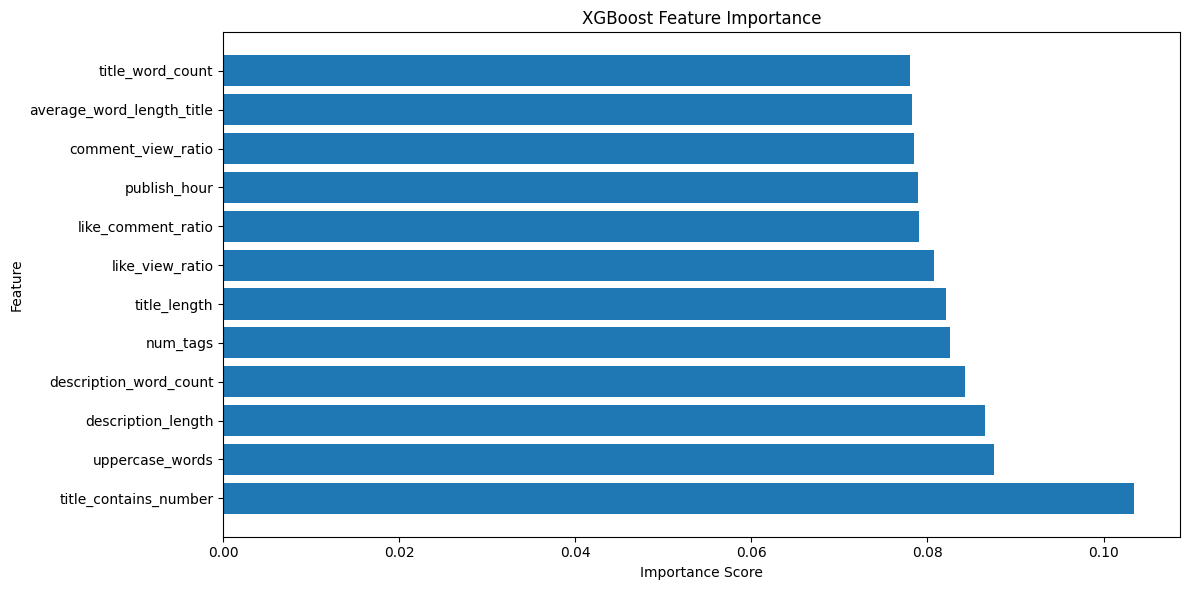


Feature Importance Ranking:
                  Feature  Importance
    title_contains_number    0.103504
          uppercase_words    0.087558
       description_length    0.086561
   description_word_count    0.084308
                 num_tags    0.082540
             title_length    0.082157
          like_view_ratio    0.080762
       like_comment_ratio    0.079074
             publish_hour    0.078889
       comment_view_ratio    0.078437
average_word_length_title    0.078210
         title_word_count    0.077998


In [33]:
# Plot Feature Importance
import matplotlib.pyplot as plt

# Get feature importances
feature_importance = model.feature_importances_
feature_names = features

# Create a sorted list
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importance
}).sort_values('Importance', ascending=False)

# Plot
plt.figure(figsize=(12, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.title('XGBoost Feature Importance')
plt.tight_layout()
plt.show()

print("\nFeature Importance Ranking:")
print(importance_df.to_string(index=False))


In [34]:
# Display sample predictions with class names
print("Sample predictions (first 10 test samples):")
print("\nPredicted classes:")
print(le.inverse_transform(y_pred[:10]))
print("\nActual classes:")
print(le.inverse_transform(y_test[:10]))


Sample predictions (first 10 test samples):

Predicted classes:
['High' 'High' 'High' 'Low' 'High' 'High' 'Viral' 'High' 'Medium' 'High']

Actual classes:
['High' 'High' 'High' 'Low' 'High' 'High' 'Viral' 'High' 'Medium' 'High']


In [35]:
# Summary of Model Performance
print("\n" + "="*50)
print("MODEL TRAINING COMPLETE")
print("="*50)
print(f"\nAccuracy Score: {accuracy_score(y_test, y_pred):.4f}")
print(f"Training set has {X_train.shape[0]} samples with {X_train.shape[1]} features")
print(f"Test set has {X_test.shape[0]} samples")
print(f"\nClass distribution in test set:")
print(pd.Series(le.inverse_transform(y_test)).value_counts())



MODEL TRAINING COMPLETE

Accuracy Score: 0.7278
Training set has 29432 samples with 12 features
Test set has 7359 samples

Class distribution in test set:
High      3038
Medium    2240
Viral     1523
Low        558
Name: count, dtype: int64


## End of Model Pipeline

All steps completed successfully! The model has been trained, evaluated, and visualized.


# Make Predictions on New Videos


In [36]:
# Function to predict success category for a new video
def predict_video_success(title, description, tags, views, likes, dislikes, comment_count, publish_hour):
    """
    Predict YouTube video success category based on metadata.
    
    Parameters:
    -----------
    title : str
        Video title
    description : str
        Video description
    tags : str
        Tags separated by '|' (pipe character)
    views : int
        Number of views
    likes : int
        Number of likes
    dislikes : int
        Number of dislikes
    comment_count : int
        Number of comments
    publish_hour : int
        Hour of publication (0-23)
    
    Returns:
    --------
    dict with prediction and feature values
    """
    
    # Create feature dictionary
    input_data = {
        'title_length': len(title),
        'description_length': len(description),
        'num_tags': len(tags.split('|')) if tags else 0,
        'publish_hour': publish_hour,
        'like_view_ratio': likes / views if views > 0 else 0,
        'comment_view_ratio': comment_count / (views + 1),
        'like_comment_ratio': likes / (comment_count + 1),
        'uppercase_words': sum(1 for word in title.split() if word.isupper()),
        'title_contains_number': 1 if any(char.isdigit() for char in title) else 0,
        'title_word_count': len(title.split()),
        'description_word_count': len(description.split()),
        'average_word_length_title': sum(len(word) for word in title.split()) / len(title.split()) if len(title.split()) > 0 else 0
    }
    
    # Create DataFrame with same feature order as training
    input_df = pd.DataFrame([input_data])[features]
    
    # Make prediction
    prediction_encoded = model.predict(input_df)[0]
    prediction_proba = model.predict_proba(input_df)[0]
    prediction_category = le.inverse_transform([prediction_encoded])[0]
    
    # Get confidence for predicted class
    confidence = prediction_proba[prediction_encoded] * 100
    
    return {
        'predicted_category': prediction_category,
        'confidence': confidence,
        'probabilities': dict(zip(class_names, prediction_proba * 100)),
        'features': input_data
    }

print("✓ Prediction function ready! Use predict_video_success() to get predictions.")


✓ Prediction function ready! Use predict_video_success() to get predictions.


In [37]:
# Example prediction - modify these values to test different videos
print("=" * 60)
print("EXAMPLE PREDICTION")
print("=" * 60)

# Example video 1: A potential viral video
result1 = predict_video_success(
    title="How I Made $10,000 in 30 Days - Full Tutorial #money #tips",
    description="In this video, I share my complete strategy for making money online. Learn the exact steps I took to earn $10,000 in just 30 days. Full breakdown of tools, platforms, and techniques included. Watch till the end for the bonus tip!",
    tags="money|earn|tutorial|tips|online|business|side hustle|passive income",
    views=500000,
    likes=15000,
    dislikes=200,
    comment_count=3000,
    publish_hour=14  # 2 PM
)

print(f"\nVideo 1: '{result1['features'].keys()}'")
print(f"  Predicted Category: {result1['predicted_category']}")
print(f"  Confidence: {result1['confidence']:.2f}%")
print(f"  \n  Class Probabilities:")
for category, prob in result1['probabilities'].items():
    print(f"    - {category:10s}: {prob:6.2f}%")

print("\n" + "-" * 60)

# Example video 2: A low-engagement video
result2 = predict_video_success(
    title="Random Vlog - Just Talking",
    description="Just a regular vlog where I talk about my day.",
    tags="vlog|daily",
    views=5000,
    likes=50,
    dislikes=5,
    comment_count=10,
    publish_hour=18  # 6 PM
)

print(f"\nVideo 2: '{result2['features'].keys()}'")
print(f"  Predicted Category: {result2['predicted_category']}")
print(f"  Confidence: {result2['confidence']:.2f}%")
print(f"  \n  Class Probabilities:")
for category, prob in result2['probabilities'].items():
    print(f"    - {category:10s}: {prob:6.2f}%")


EXAMPLE PREDICTION

Video 1: 'dict_keys(['title_length', 'description_length', 'num_tags', 'publish_hour', 'like_view_ratio', 'comment_view_ratio', 'like_comment_ratio', 'uppercase_words', 'title_contains_number', 'title_word_count', 'description_word_count', 'average_word_length_title'])'
  Predicted Category: Medium
  Confidence: 59.69%
  
  Class Probabilities:
    - High      :  32.93%
    - Low       :   6.40%
    - Medium    :  59.69%
    - Viral     :   0.98%

------------------------------------------------------------

Video 2: 'dict_keys(['title_length', 'description_length', 'num_tags', 'publish_hour', 'like_view_ratio', 'comment_view_ratio', 'like_comment_ratio', 'uppercase_words', 'title_contains_number', 'title_word_count', 'description_word_count', 'average_word_length_title'])'
  Predicted Category: Medium
  Confidence: 79.40%
  
  Class Probabilities:
    - High      :  16.15%
    - Low       :   1.98%
    - Medium    :  79.40%
    - Viral     :   2.47%


In [38]:
# Interactive Prediction Tool - Edit values below and run this cell
print("=" * 60)
print("INTERACTIVE PREDICTION TOOL")
print("=" * 60)
print("\nEdit the values below and run this cell to make a prediction\n")

# ============ EDIT THESE VALUES ============
video_title = "Best Gaming Moments 2024 - Reaction Compilation"
video_description = "Check out the best gaming moments from 2024! This compilation includes crazy clips, epic fails, and hilarious moments. Don't forget to like and subscribe for more content. Thanks for watching!"
video_tags = "gaming|funny|compilation|reaction|moments|2024|clips|viral"
video_views = 250000
video_likes = 8500
video_dislikes = 120
video_comment_count = 1200
video_publish_hour = 19  # 7 PM
# ==========================================

# Make prediction
result = predict_video_success(
    title=video_title,
    description=video_description,
    tags=video_tags,
    views=video_views,
    likes=video_likes,
    dislikes=video_dislikes,
    comment_count=video_comment_count,
    publish_hour=video_publish_hour
)

# Display results
print(f"Title: {video_title}")
print(f"Description: {video_description[:80]}...")
print(f"\nMetrics:")
print(f"  Views: {video_views:,}")
print(f"  Likes: {video_likes:,}")
print(f"  Comments: {video_comment_count:,}")
print(f"  Publish Hour: {video_publish_hour}:00")

print(f"\n{'='*60}")
print(f"PREDICTION RESULT")
print(f"{'='*60}")
print(f"\n🎯 Predicted Category: {result['predicted_category'].upper()}")
print(f"💯 Confidence: {result['confidence']:.2f}%")

print(f"\nProbability Breakdown:")
# Sort by probability for better visualization
sorted_probs = sorted(result['probabilities'].items(), key=lambda x: x[1], reverse=True)
for category, prob in sorted_probs:
    bar_length = int(prob / 5)  # Scale to 0-20 for visualization
    bar = "█" * bar_length + "░" * (20 - bar_length)
    print(f"  {category:10s} [{bar}] {prob:6.2f}%")

print(f"\nKey Features Used:")
input_features = result['features']
top_features = ['title_contains_number', 'uppercase_words', 'description_length', 
                'num_tags', 'like_view_ratio', 'comment_view_ratio']
for feat in top_features:
    if feat in input_features:
        print(f"  - {feat}: {input_features[feat]}")


INTERACTIVE PREDICTION TOOL

Edit the values below and run this cell to make a prediction

Title: Best Gaming Moments 2024 - Reaction Compilation
Description: Check out the best gaming moments from 2024! This compilation includes crazy cli...

Metrics:
  Views: 250,000
  Likes: 8,500
  Comments: 1,200
  Publish Hour: 19:00

PREDICTION RESULT

🎯 Predicted Category: HIGH
💯 Confidence: 51.94%

Probability Breakdown:
  High       [██████████░░░░░░░░░░]  51.94%
  Medium     [██████░░░░░░░░░░░░░░]  32.69%
  Viral      [█░░░░░░░░░░░░░░░░░░░]   8.93%
  Low        [█░░░░░░░░░░░░░░░░░░░]   6.44%

Key Features Used:
  - title_contains_number: 1
  - uppercase_words: 0
  - description_length: 192
  - num_tags: 8
  - like_view_ratio: 0.034
  - comment_view_ratio: 0.0047999808000768


In [39]:
import joblib

joblib.dump(model, "../models/youtube_model.pkl")
joblib.dump(le, "../models/label_encoder.pkl")


['../models/label_encoder.pkl']